In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import torch
import ot
from misc.torchot import *
import matplotlib.pyplot as plt
dev = torch.device('cuda')

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
x_grid.shape

NameError: name 'x_grid' is not defined

In [3]:
def getDistSqrTorus(x,y):
    dim = 1
    if (x.ndim == 2):
        dim = x.shape[1]
    m = x.shape[0]
    n = y.shape[0]
    return torch.sum(((x.reshape((m,1,dim))-y.reshape((1,n,dim)) + 0.5)%1 - 0.5)**2, dim = 2)

def cost(X,Y):
    
    return getDistSqrTorus(X,Y)

def dens_gauss_shift(X, Y, shift, std, shift_prob=0.5):
    """
    X, Y same shape torch arrays to describe point clouds
    shift = shift of second diagonal
    std = standard deviation of both diagonals
    shift_prob = probability of going to the se
    """
    o = torch.ceil(torch.tensor(4 * std, device = dev))
    
    a = (Y - X).reshape((*X.shape, 1))
    z = torch.arange(-o, o+1, dtype=torch.float32, device = dev).reshape((*[1 for _ in X.shape], -1))
    
    d0 = 1 / ((2 * torch.pi)**.5 * std) * torch.sum(torch.exp(-(a - z)**2 / (2 * std**2)), axis=-1)
    d1 = 1 / ((2 * torch.pi)**.5 * std) * torch.sum(torch.exp(-(a - shift - z)**2 / (2 * std**2)), axis=-1)
    
    return shift_prob * d1 + (1 - shift_prob) * d0

## Model Setup (1D)

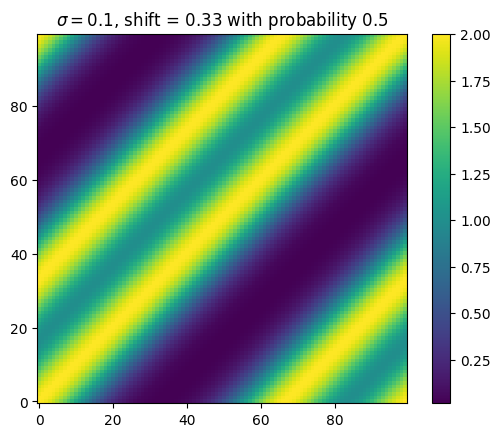

In [4]:
shift = 1/3
std = .1
shift_prob = .5

##Show Model
x_grid = torch.linspace(0,1,101, device = dev)[:-1]
y_grid = torch.linspace(0,1,101, device = dev)[:-1]
x_grid, y_grid = torch.meshgrid(x_grid, y_grid,indexing='xy')
dens = dens_gauss_shift(x_grid, y_grid, shift, std, shift_prob=0.5)
plt.imshow(dens.cpu(), origin='lower')
plt.title(f"$\sigma = {std}$, shift = {shift:.2f} with probability {shift_prob}")
plt.colorbar()
plt.show()

## Sample Points

In [5]:
Npts = 300
x = torch.rand(Npts, device = dev)
noise = torch.randn_like(x) * std
sft_bool = torch.bernoulli(torch.tensor([shift_prob]*Npts, device = dev))
y = (x + noise + sft_bool * shift)%1

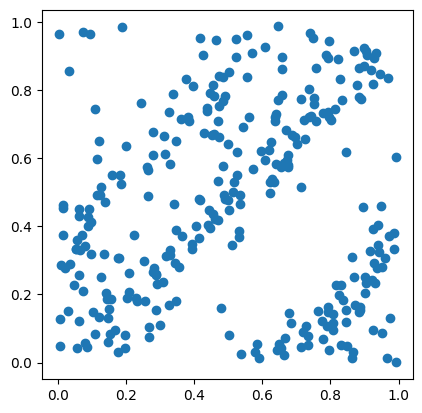

In [6]:
#Plot point samples
plt.scatter(x.cpu(),y.cpu())
plt.gca().set_aspect('equal')

## calculate $T_{\pi_N}$

In [7]:
#create epsilon list:
epsL = reversed(torch.logspace(-3,-1, 50, device = dev))

#calculate the EOT plans for different epsilon
CostX, alphaX, betaX = SolveEOT(cost(x,x), epsL)
CostY, alphaY, betaY = SolveEOT(cost(y,y), epsL)

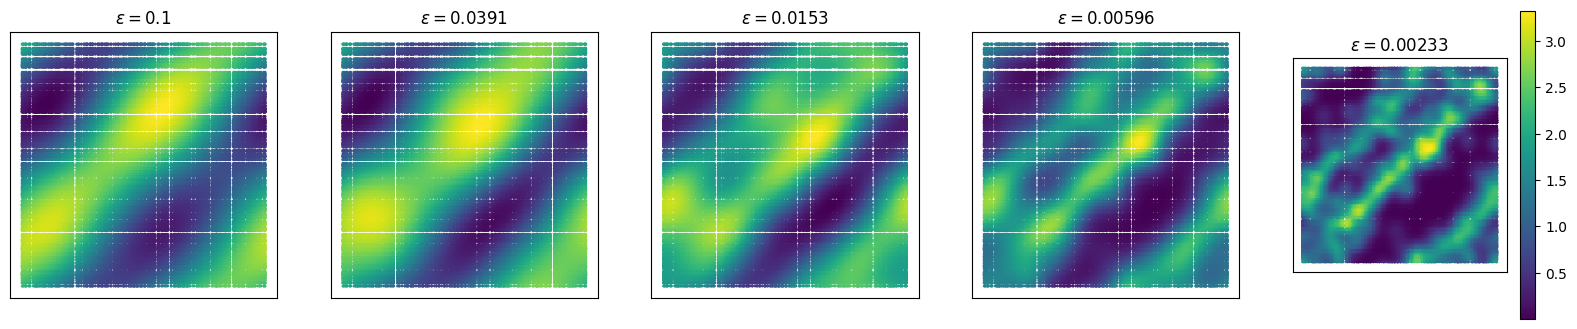

In [13]:
#empirical support:
x_supp, y_supp = torch.meshgrid(x, y, indexing='xy')
fig, axs = plt.subplots(ncols = 5, figsize = (20,4))
for i, ax in zip([0,10,20,30,40,49],axs):
    Tx = torch.exp((-cost(x,x) + alphaX[i,:,None] + betaX[i,None,:])/epsL[i])/Npts
    Ty = torch.exp((-cost(y,y) + alphaY[i,:,None] + betaY[i,None,:])/epsL[i])/Npts
    M = (Ty @ Tx)*Npts
    im = ax.scatter(x_supp.cpu().ravel(), y_supp.cpu().ravel(), c = M.cpu().ravel(), s=1)
    ax.set_aspect('equal')
    ax.set_title(f"$\epsilon = {epsL[i]:.3}$")
    ax.set_xticks([])
    ax.set_yticks([])
fig.colorbar(im, orientation='vertical')

## Out of sample emb

In [17]:
#take arbitrary grid 
ePts = 1000
x_e = torch.rand(size=(ePts,), device = dev)
y_e = torch.rand(size=(ePts,), device = dev)
x_e = torch.linspace(0,1,ePts,device = dev)[:,None]
y_e = torch.linspace(0,1,ePts,device = dev)[:,None]

In [18]:
#extension of the dual potentials to gird
pot_x = -epsL[:,None] * (torch.logsumexp((-cost(x_e,x[:,None])[None,...] + betaX[:,None,:])/epsL[:,None,None], dim = 2) - torch.log(torch.tensor(Npts,device = dev))) 
pot_y = -epsL[:,None] * (torch.logsumexp((-cost(y[:,None],y_e)[None,...] + alphaY[:,:,None])/epsL[:,None,None], dim = 1) - torch.log(torch.tensor(Npts,device = dev))) 
KX = torch.exp((-cost(x_e,x[:,None])[None,...] + betaX[:,None,:] + pot_x[:,:,None])/epsL[:,None,None])
KY = torch.exp((-cost(y[:,None],y_e)[None,...] + alphaY[:,:,None] + pot_y[:,None,:])/epsL[:,None,None])
res = torch.bmm(KX,KY)/Npts

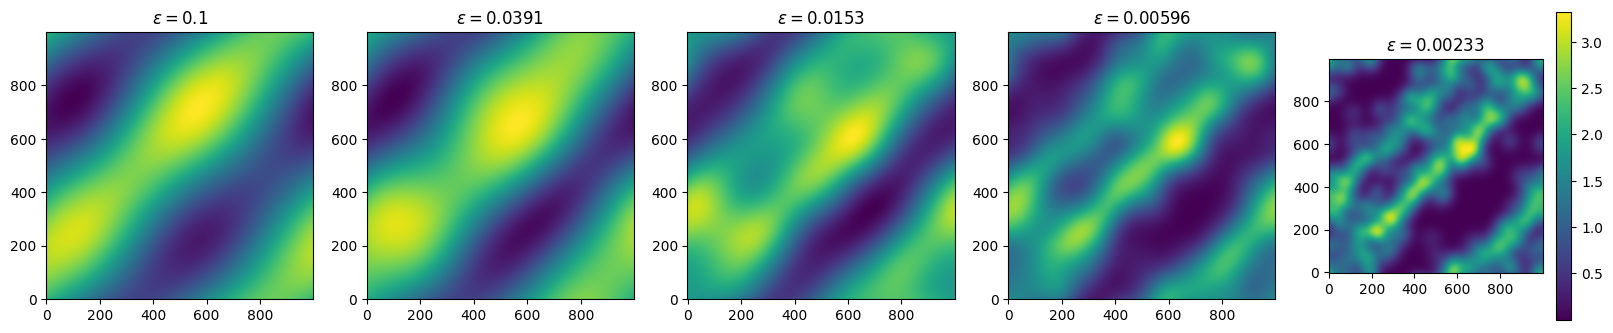

In [19]:
fig, ax = plt.subplots(ncols = 5, figsize = (20,4))
for i, ax in zip([0,10,20,30,40,49],ax):
    im = ax.imshow(res[i].T.cpu(), origin='lower')
    ax.set_title(f"$\epsilon = {epsL[i]:.3}$")
fig.colorbar(im, orientation='vertical')